## This notebook contains the code used for generating the panels shown in Figure 5D.
The aim was to calculate whether DRNs were enriched in known RNA-binding sites. 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
from scipy.stats import hypergeom
from matplotlib import rcParams
from collections import defaultdict
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['axes.formatter.useoffset'] = False


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def formatAxes(ax,text_size=10,xlim=None,xlabel=None,xticks=None,xticklabels=None,ylim=None,yticks=None,ylabel=None,yticklabels=None):
    """ to tweak the plotting of the axes as well as the fontsize """
    for loc,spine in list(ax.spines.items()):
        if loc == 'left': # settings for the y-axis
            if yticklabels and not yticks:
                sys.stderr.write("Need to provide a list wiht both y-labels and y-ticks!")
            if yticks:
                ax.yaxis.set_ticks_position('left')
                ax.yaxis.set_tick_params(direction='out')
                spine.set_visible(True)
                spine.set_position(("outward",1))
                spine.set_smart_bounds(True)
                ax.set_yticks(yticks)
                if ylim:
                    ax.set_ylim(ylim)
                if yticklabels:
                    ax.set_yticklabels(yticklabels,fontsize=text_size)
            else:
                spine.set_visible(False)
                ax.set_yticklabels([])
                ax.tick_params(axis='y',which='both',length=0)
                
            if ylabel:
                ax.set_ylabel(ylabel,fontsize=text_size,rotation=0,labelpad=160)
                ax.get_yaxis().set_label_coords(-0.1,0.5)
        elif loc == 'bottom': # settings for x-axis
            if xticks:
                spine.set_position('zero')
                spine.set_visible(False)
                spine.set_smart_bounds(False)
                ax.set_xticks(xticks)
                ax.tick_params(axis='x',which='both',length=0)
                if xlim:
                    ax.set_xlim(xlim)
                if xticklabels:
                    ax.set_xticklabels(xticklabels,fontsize=text_size)
            else:
                spine.set_visible(False)
                ax.set_xticklabels([])
                ax.tick_params(axis='x',which='both',length=0)
                
            if xlabel:
                ax.tick_params(axis='x',which='both',length=0)
                ax.set_xlabel(xlabel,fontsize=text_size+2)
                ax.xaxis.labelpad = 10
        else:
            spine.set_visible(False)
    ax.patch.set_visible(False)

### Loading the big dataframe:

In [3]:
alldata = pd.read_csv('../../../Data/New_data_table_Xist.txt',\
                      sep="\t",\
                      header=0,\
                      index_col=0)

### Masking positions not considered by deltaSHAPE:

In [4]:
positionstomask = alldata[(alldata["SHAPE_reactivity_ex_vivo_1"] < -900) | 
                          (alldata["SHAPE_reactivity_ex_vivo_2"] < -900) |
                          (alldata["SHAPE_reactivity_in_cell_1"] < -900) | 
                          (alldata["SHAPE_reactivity_in_cell_2"] < -900)].index
print(len(positionstomask))
alldata.loc[positionstomask,alldata.columns[11:]] = np.nan

2517


### Setting the threshold for calling DRNs in the diffBUM-HMM data

In [5]:
threshold = 0.95

In [6]:
alldata.head()

,nucleotide,CELF1,FUS,HuR,PTBP1,RBFOX2,TARDBP,SHAPE_reactivity_ex_vivo_1,SHAPE_reactivity_ex_vivo_2,SHAPE_reactivity_in_cell_1,...,dStruct_scaled,unmodified,ex_vivo,in_vivo,both,scaled_unmodified,scaled_ex_vivo,scaled_in_vivo,scaled_both,base_paired_to
1,C,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,G,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,T,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### How many nucleotides are diff modified in the diffBUM-HMM data in ex vivo and in vivo?

In [7]:
ex_vivo_count = len(alldata[alldata.ex_vivo >= threshold])
in_vivo_count = len(alldata[alldata.in_vivo >= threshold])
ex_vivo_norm_count = len(alldata[alldata.scaled_ex_vivo >= threshold])
in_vivo_norm_count = len(alldata[alldata.scaled_in_vivo >= threshold])

print("ex_vivo:\t%s\nin_vivo:\t%s\nex_vivo_norm:\t%s\nin_vivo_norm:\t%s" % \
     (ex_vivo_count,in_vivo_count,ex_vivo_norm_count,in_vivo_norm_count))

ex_vivo:	1164
in_vivo:	142
ex_vivo_norm:	1739
in_vivo_norm:	188


In [8]:
print(ex_vivo_count/in_vivo_count)

8.19718309859155


In [9]:
print(ex_vivo_norm_count/in_vivo_norm_count)

9.25


### Count number of DRNs in diffBUM_HMM data:

In [10]:
proteins = ["CELF1","FUS","HuR","PTBP1","RBFOX2","TARDBP"]
samples = ["in_vivo","in_vivo_scaled","ex_vivo","ex_vivo_scaled",\
           "dSHAPE_in_vivo_1","dSHAPE_in_vivo_2","dSHAPE_ex_vivo_1","dSHAPE_ex_vivo_2"]
proteincount = pd.DataFrame(0,index=proteins,columns=samples)

In [11]:
num_diff_nucl_ex_vivo = len(alldata[alldata.ex_vivo >= threshold].index)
num_diff_nucl_in_vivo = len(alldata[alldata.in_vivo >= threshold].index)

print("ex_vivo\t",num_diff_nucl_ex_vivo)
print("in_vivo\t",num_diff_nucl_in_vivo)

ex_vivo	 1164
in_vivo	 142


### Count number of DRNs in deltaSHAPE data:

In [12]:
num_diff_nucl_ex_vivo_deltaSHAPE_1 = len(alldata[alldata.deltaSHAPE_rep1 > 0].index)
num_diff_nucl_in_vivo_deltaSHAPE_1 = len(alldata[alldata.deltaSHAPE_rep1 < 0].index)
        
print("ex_vivo\t",num_diff_nucl_ex_vivo_deltaSHAPE_1)
print("in_vivo\t",num_diff_nucl_in_vivo_deltaSHAPE_1)

print(num_diff_nucl_ex_vivo_deltaSHAPE_1/num_diff_nucl_in_vivo_deltaSHAPE_1)

ex_vivo	 460
in_vivo	 337
1.3649851632047478


In [13]:
num_diff_nucl_ex_vivo_deltaSHAPE_2 = len(alldata[alldata.deltaSHAPE_rep2 > 0].index)
num_diff_nucl_in_vivo_deltaSHAPE_2 = len(alldata[alldata.deltaSHAPE_rep2 < 0].index)
        
print("ex_vivo\t",num_diff_nucl_ex_vivo_deltaSHAPE_2)
print("in_vivo\t",num_diff_nucl_in_vivo_deltaSHAPE_2)

print(num_diff_nucl_ex_vivo_deltaSHAPE_2/num_diff_nucl_in_vivo_deltaSHAPE_2)

ex_vivo	 510
in_vivo	 428
1.191588785046729


### How many binding sites for each protein were found that overlapped with modified nucleotides in the ex vivo data?

In [14]:
morereactive_ex_vivo = alldata[alldata.ex_vivo >= threshold]
morereactive_in_vivo = alldata[alldata.in_vivo >= threshold]

morereactive_ex_vivo_deltaSHAPE_1 = alldata[alldata.deltaSHAPE_rep1 > 0]
morereactive_in_vivo_deltaSHAPE_1 = alldata[alldata.deltaSHAPE_rep1 < 0]

morereactive_ex_vivo_deltaSHAPE_2 = alldata[alldata.deltaSHAPE_rep2 > 0]
morereactive_in_vivo_deltaSHAPE_2 = alldata[alldata.deltaSHAPE_rep2 < 0]

proteins = ["CELF1","FUS","HuR","PTBP1","RBFOX2","TARDBP"]

In [15]:
proteins

['CELF1', 'FUS', 'HuR', 'PTBP1', 'RBFOX2', 'TARDBP']

In [16]:
dict_total_binding_sites_differential_ex_vivo = {}
dict_total_binding_sites_differential_in_vivo = {}

dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_1 = {}
dict_total_binding_sites_differential_in_vivo_deltaSHAPE_1 = {}

dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_2 = {}
dict_total_binding_sites_differential_in_vivo_deltaSHAPE_2 = {}

for protein in proteins:
    dict_total_binding_sites_differential_ex_vivo[protein] = morereactive_ex_vivo[protein].sum()
    dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_1[protein] = morereactive_ex_vivo_deltaSHAPE_1[protein].sum()
    dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_2[protein] = morereactive_ex_vivo_deltaSHAPE_2[protein].sum()

    
for protein in proteins:
    dict_total_binding_sites_differential_in_vivo[protein] = morereactive_in_vivo[protein].sum()
    dict_total_binding_sites_differential_in_vivo_deltaSHAPE_1[protein] = morereactive_in_vivo_deltaSHAPE_1[protein].sum()
    dict_total_binding_sites_differential_in_vivo_deltaSHAPE_2[protein] = morereactive_in_vivo_deltaSHAPE_2[protein].sum()

print("diffBUM-HMM:")
print(dict_total_binding_sites_differential_ex_vivo)
print(dict_total_binding_sites_differential_in_vivo)
print("\ndeltaSHAPE replicates:")
print("rep1")
print(dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_1)
print(dict_total_binding_sites_differential_in_vivo_deltaSHAPE_1)
print("rep2")
print(dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_2)
print(dict_total_binding_sites_differential_in_vivo_deltaSHAPE_2)

diffBUM-HMM:
{'CELF1': 36, 'FUS': 271, 'HuR': 61, 'PTBP1': 28, 'RBFOX2': 2, 'TARDBP': 39}
{'CELF1': 11, 'FUS': 35, 'HuR': 15, 'PTBP1': 7, 'RBFOX2': 1, 'TARDBP': 9}

deltaSHAPE replicates:
rep1
{'CELF1': 69, 'FUS': 70, 'HuR': 131, 'PTBP1': 74, 'RBFOX2': 0, 'TARDBP': 4}
{'CELF1': 16, 'FUS': 98, 'HuR': 16, 'PTBP1': 11, 'RBFOX2': 0, 'TARDBP': 4}
rep2
{'CELF1': 54, 'FUS': 133, 'HuR': 75, 'PTBP1': 50, 'RBFOX2': 3, 'TARDBP': 6}
{'CELF1': 10, 'FUS': 120, 'HuR': 19, 'PTBP1': 9, 'RBFOX2': 0, 'TARDBP': 13}


In [17]:
##IN CELL

In [18]:
morereactive_in_vivo = alldata[alldata.in_vivo >= threshold]

In [19]:
for protein in proteins:
    print("%s\ttotal_count:\t%s" % (protein,morereactive_in_vivo[protein].sum()))

CELF1	total_count:	11
FUS	total_count:	35
HuR	total_count:	15
PTBP1	total_count:	7
RBFOX2	total_count:	1
TARDBP	total_count:	9


In [20]:
#COUNTING UP TOTAL NUMBER OF PROTEIN BINDING SITES, EXCLUDING REGIONS NOT USED BY DIFFBUMHM

dict_total_binding_sites={}
for protein in proteins:
    dict_total_binding_sites[protein]=alldata[protein].sum()
    
print(dict_total_binding_sites)

{'CELF1': 802, 'FUS': 3694, 'HuR': 1149, 'PTBP1': 604, 'RBFOX2': 66, 'TARDBP': 534}


### diffBUM_HMM individual sites:

         ex_vivo   in_vivo
CELF1   0.003144  0.028364
FUS     0.002074  0.039432
HuR     0.011929  0.019097
PTBP1   0.010975       NaN
RBFOX2       NaN       NaN
TARDBP       NaN  0.016335


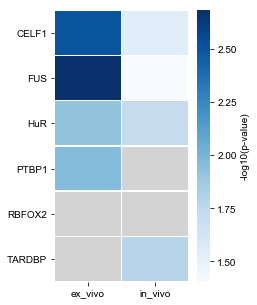

In [21]:
'''
Written by Sander
“M" would be total number of Xist nucleotides.
“n” would in your case be total number of nucleotides that are part of an RNA-binding site (i.e. FUS, etc).
“x” would be the total number of differentially modified nucleotides in ex vivo that overlap with the RNA-binding site.
“N” would be the total number of differentially modified nucleotides in ex vivo.
'''
diffbumhmmpvalues = defaultdict(lambda: defaultdict(float))

#Length Xist
M = 17918

for protein in proteins:
    n = int(dict_total_binding_sites[protein])
    
    #ex_vivo
    N = num_diff_nucl_ex_vivo
    x = dict_total_binding_sites_differential_ex_vivo[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    diffbumhmmpvalues["ex_vivo"][protein] = p_value
    
    #in_vivo
    N = num_diff_nucl_in_vivo
    x = dict_total_binding_sites_differential_in_vivo[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    diffbumhmmpvalues["in_vivo"][protein] = p_value

output = pd.DataFrame.from_dict(diffbumhmmpvalues,orient='columns')
output = output.mask(output > 0.05)
print(output)
output = output.apply(np.log10)*-1


fig,ax = plt.subplots(figsize=[3,5])
mask = output.isnull()
ax = sns.heatmap(output,cmap="Blues",linewidths=.5,mask=mask,cbar_kws={'label':'-log10(p-value)'})
ax.set_facecolor("lightgrey")
ax.set_yticklabels(ax.get_yticklabels(),rotation=None,horizontalalignment='right')

fig.savefig("Figure_5D_panel_I.pdf",dpi=400)

### deltaSHAPE individual sites:
Replicate 1:

             ex_vivo   in_vivo
CELF1   4.183573e-19       NaN
FUS     5.728584e-04  0.000048
HuR     1.100427e-50  0.043091
PTBP1   6.436755e-30       NaN
RBFOX2           NaN       NaN
TARDBP  1.354683e-03  0.016989


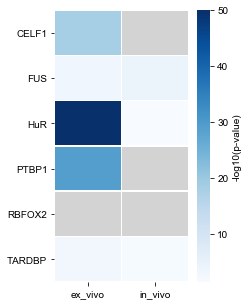

In [22]:
'''
Written by Sander
“M" would be total number of Xist nucleotides.
“n” would in your case be total number of nucleotides that are part of an RNA-binding site (i.e. FUS, etc).
“x” would be the total number of differentially modified nucleotides in ex vivo that overlap with the RNA-binding site.
“N” would be the total number of differentially modified nucleotides in ex vivo.
'''
deltashapepvalues = defaultdict(lambda: defaultdict(float))

#Length Xist
M = 17918

for protein in proteins:
    n = int(dict_total_binding_sites[protein])
    
    #ex_vivo
    N = num_diff_nucl_ex_vivo_deltaSHAPE_1
    x = dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_1[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    deltashapepvalues["ex_vivo"][protein] = p_value

    #in_vivo
    N = num_diff_nucl_in_vivo_deltaSHAPE_1
    x = dict_total_binding_sites_differential_in_vivo_deltaSHAPE_1[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    deltashapepvalues["in_vivo"][protein] = p_value

output = pd.DataFrame.from_dict(deltashapepvalues,orient='columns')
output = output.mask(output > 0.05)
print(output)
output = output.apply(np.log10)*-1

fig,ax = plt.subplots(figsize=[3,5])
mask = output.isnull()
ax = sns.heatmap(output,cmap="Blues",linewidths=.5,mask=mask,cbar_kws={'label':'-log10(p-value)'})
ax.set_facecolor("lightgrey")
ax.set_yticklabels(ax.get_yticklabels(),rotation=None,horizontalalignment='right')

fig.savefig("Figure_5D_panel_II.pdf",dpi=400)

### deltaSHAPE individual sites:
Replicate 2:

             ex_vivo       in_vivo
CELF1            NaN           NaN
FUS     5.201918e-18  2.760868e-60
HuR     4.915669e-02  1.091283e-03
PTBP1   1.320345e-02  2.911203e-02
RBFOX2           NaN           NaN
TARDBP  6.351995e-10  2.412169e-04


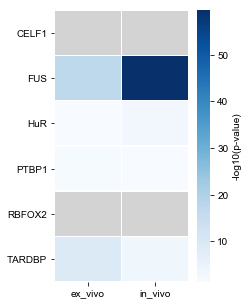

In [23]:
'''
Written by Sander
“M" would be total number of Xist nucleotides.
“n” would in your case be total number of nucleotides that are part of an RNA-binding site (i.e. FUS, etc).
“x” would be the total number of differentially modified nucleotides in ex vivo that overlap with the RNA-binding site.
“N” would be the total number of differentially modified nucleotides in ex vivo.
'''
deltashapepvalues = defaultdict(lambda: defaultdict(float))

#Length Xist
M = 17918

for protein in proteins:
    n = int(dict_total_binding_sites[protein])
    
    #ex_vivo
    N = num_diff_nucl_ex_vivo
    x = dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_2[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    deltashapepvalues["ex_vivo"][protein] = p_value

    #in_vivo
    N = num_diff_nucl_in_vivo
    x = dict_total_binding_sites_differential_in_vivo_deltaSHAPE_2[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    deltashapepvalues["in_vivo"][protein] = p_value

output = pd.DataFrame.from_dict(deltashapepvalues,orient='columns')
output = output.mask(output > 0.05)
print(output)
output = output.apply(np.log10)*-1


fig,ax = plt.subplots(figsize=[3,5])
mask = output.isnull()
ax = sns.heatmap(output,cmap="Blues",linewidths=.5,mask=mask,cbar_kws={'label':'-log10(p-value)'})
ax.set_facecolor("lightgrey")
ax.set_yticklabels(ax.get_yticklabels(),rotation=None,horizontalalignment='right')

fig.savefig("Figure_5D_panel_III.pdf",dpi=400)

### All sites diffBUM_HMM

In [24]:
'''
Written by Sander
“M" would be total number of Xist nucleotides.
“n” would in your case be total number of nucleotides that are part of an RNA-binding site (i.e. FUS, etc).
“x” would be the total number of differentially modified nucleotides in ex vivo that overlap with the RNA-binding site.
“N” would be the total number of differentially modified nucleotides in ex vivo.
'''

totals_binding_sites = 0
totals_binding_sites_differential_ex_vivo = 0
totals_binding_sites_differential_in_vivo = 0

for protein in proteins:
    totals_binding_sites += int(dict_total_binding_sites[protein])
    totals_binding_sites_differential_ex_vivo += dict_total_binding_sites_differential_ex_vivo[protein]
    totals_binding_sites_differential_in_vivo += dict_total_binding_sites_differential_in_vivo[protein]
    
M = 17918
#ex_vivo
N = num_diff_nucl_ex_vivo
n = totals_binding_sites
x = totals_binding_sites_differential_ex_vivo

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('ex_vivo\t%s' % p_value)

#in_vivo
N = num_diff_nucl_in_vivo
n = totals_binding_sites
x = totals_binding_sites_differential_in_vivo 

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('in_vivo\t%s' % p_value)

ex_vivo	0.02208146966494196
in_vivo	1.909091295478967e-05


### All sites deltaSHAPE
Replicate 1:

In [25]:
totals_binding_sites = 0
totals_binding_sites_differential_ex_vivo = 0
totals_binding_sites_differential_in_vivo = 0

for protein in proteins:
    totals_binding_sites += int(dict_total_binding_sites[protein])
    totals_binding_sites_differential_ex_vivo += dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_1[protein]
    totals_binding_sites_differential_in_vivo += dict_total_binding_sites_differential_in_vivo_deltaSHAPE_1[protein]
    
M = 17918
#ex_vivo
N = num_diff_nucl_ex_vivo_deltaSHAPE_1
n = totals_binding_sites
x = totals_binding_sites_differential_ex_vivo

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('ex_vivo\t%s' % p_value)

#in_vivo
N = num_diff_nucl_in_vivo_deltaSHAPE_1
n = totals_binding_sites
x = totals_binding_sites_differential_in_vivo 

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('in_vivo\t%s' % p_value)

ex_vivo	1.5473614427772841e-61
in_vivo	0.008471001572248626


### All sites deltaSHAPE
Replicate 2:

In [26]:
totals_binding_sites = 0
totals_binding_sites_differential_ex_vivo = 0
totals_binding_sites_differential_in_vivo = 0

for protein in proteins:
    totals_binding_sites += int(dict_total_binding_sites[protein])
    totals_binding_sites_differential_ex_vivo += dict_total_binding_sites_differential_ex_vivo_deltaSHAPE_2[protein]
    totals_binding_sites_differential_in_vivo += dict_total_binding_sites_differential_in_vivo_deltaSHAPE_2[protein]
    
M = 17918
#ex_vivo
N = num_diff_nucl_ex_vivo_deltaSHAPE_2
n = totals_binding_sites
x = totals_binding_sites_differential_ex_vivo

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('ex_vivo\t%s' % p_value)

#in_vivo
N = num_diff_nucl_in_vivo_deltaSHAPE_2
n = totals_binding_sites
x = totals_binding_sites_differential_in_vivo 

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('in_vivo\t%s' % p_value)

ex_vivo	1.399339836638539e-30
in_vivo	0.030222302504486653


In [27]:
print(totals_binding_sites)
print(num_diff_nucl_ex_vivo)
print(totals_binding_sites_differential_ex_vivo)

6849
1164
321


In [28]:
print(totals_binding_sites)
print(num_diff_nucl_ex_vivo_deltaSHAPE_1)
print(totals_binding_sites_differential_ex_vivo)

6849
460
321
